In [1]:
import dgl
import torch
import torch.nn as nn
import numpy as np
import networkx as nx

Using backend: pytorch


In [2]:
def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [3]:
from torch.utils.data import DataLoader

number_examples = 2000
min_number_nodes = 32
max_number_nodes = 64

num_train_examples = int(number_examples * 0.8)
num_test_examples = number_examples - num_train_examples
minibatch_size = 16

train_set = dgl.data.MiniGCDataset(num_train_examples, min_number_nodes, max_number_nodes, seed=0)
test_set = dgl.data.MiniGCDataset(num_test_examples, min_number_nodes * 2, max_number_nodes * 2, seed=0)

train_dataloader = DataLoader(
    train_set, batch_size=minibatch_size, drop_last=False, shuffle=True, collate_fn=collate)
test_dataloader = DataLoader(
    test_set, batch_size=minibatch_size, drop_last=False, shuffle=True, collate_fn=collate)

In [4]:
graph, label = train_set[0]
print(graph, label)

Graph(num_nodes=44, num_edges=132,
      ndata_schemes={}
      edata_schemes={}) tensor(0)


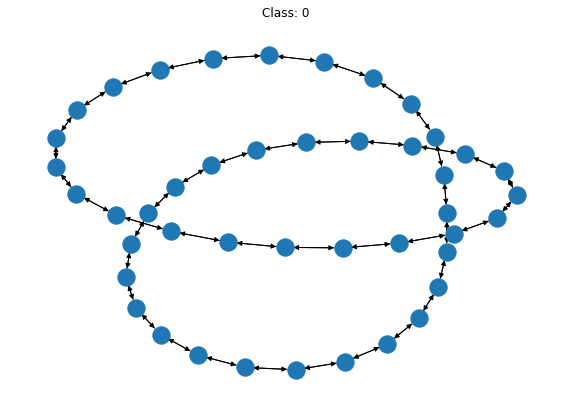

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [6]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, int(hidden_dim / 2))
        self.conv4 = GraphConv(int(hidden_dim / 2), int(hidden_dim / 2))
        self.conv5 = GraphConv(int(hidden_dim / 2), int(hidden_dim / 4))
        self.classifier = nn.Linear(int(hidden_dim / 4), num_classes)

    def forward(self, graph):
        h = graph.in_degrees().view(-1, 1).float() # Use node degree as the initial node feature
        h = self.conv1(graph, h)
        h = nn.functional.relu(h)
        h = self.conv2(graph, h)
        h = nn.functional.relu(h)
        h = self.conv3(graph, h)
        h = nn.functional.relu(h)
        h = self.conv4(graph, h)
        h = nn.functional.relu(h)
        h = self.conv5(graph, h)
        h = nn.functional.relu(h)
        graph.ndata['h'] = h
        
        global_h = dgl.mean_nodes(graph, 'h')
        return self.classifier(global_h)

In [7]:
def train(graphs, model, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs+1):
        for batched_graph, labels in train_dataloader:
            pred = model(batched_graph)
            loss = nn.functional.cross_entropy(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        num_correct = 0
        num_tests = 0
        for batched_graph, labels in test_dataloader:
            pred = model(batched_graph)
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)

        if epoch % 5 == 0:
            print('In epoch {}, training loss: {:4f}, test accuracy: {}%'.format(
                epoch, loss, (num_correct / num_tests) * 100))

In [8]:
model = model = GCN(1, 256, train_set.num_classes)
train(train_set, model, 100)

In epoch 0, training loss: 1.690089, test accuracy: 43.5%
In epoch 5, training loss: 0.656739, test accuracy: 58.5%
In epoch 10, training loss: 0.268058, test accuracy: 68.75%
In epoch 15, training loss: 0.255293, test accuracy: 69.0%
In epoch 20, training loss: 0.206010, test accuracy: 74.0%
In epoch 25, training loss: 0.405765, test accuracy: 72.0%
In epoch 30, training loss: 0.172439, test accuracy: 74.0%
In epoch 35, training loss: 0.460032, test accuracy: 70.0%
In epoch 40, training loss: 0.257052, test accuracy: 69.5%
In epoch 45, training loss: 0.151121, test accuracy: 70.25%
In epoch 50, training loss: 0.024015, test accuracy: 77.0%
In epoch 55, training loss: 0.004800, test accuracy: 86.25%
In epoch 60, training loss: 0.137131, test accuracy: 72.25%
In epoch 65, training loss: 0.206499, test accuracy: 76.25%
In epoch 70, training loss: 0.029195, test accuracy: 86.75%
In epoch 75, training loss: 0.014688, test accuracy: 83.5%
In epoch 80, training loss: 0.009233, test accuracy: